# CSE 144 Group 3
## Music Recommendation System (MRS)

In this notebook, we write the predictive model for our music recommendation system. Our work leverages modern tools including recurrent neural networks (RNN) and BERT sentence transformers...

<br>

Our work leverages this RNN model:

https://github.com/taylorhawks/RNN-music-recommender/blob/master/cloud/model.ipynb


In [1]:
# import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
import random
import torch
import os
# from torch import nn, optim
# import math
# from IPython import display
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
# from torch.utils.data import TensorDataset
# import torch.nn.functional as F
# from sklearn.preprocessing import MinMaxScaler
# import pdb
import plotly.graph_objects as go
import numpy as np

from skimage.util.shape import view_as_windows as viewW
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

# import tensorflow as tf

# import keras.backend as K
from keras.models import Sequential, load_model
# from keras.optimizers import RMSprop
from keras.layers import Dense, SimpleRNN, Input
from keras.losses import *


### Load the data

In [2]:
song_features_data = pd.read_csv('misc/processed_music_info.csv')
user_listening_data = pd.read_csv('misc/processed_user_listening_hist.csv')

# from google.colab import drive
# drive.mount('/content/drive')
# import pandas as pd
# song_features_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/music_info.csv')
# user_listening_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/user_listening_hist.csv')

### Set Random Seed

In [3]:
torch.manual_seed(24)

### Read and Display Data

In [4]:
print('# of rows of Song Data: ' + str(len(song_features_data)))
print('# of unique songs: ' + str(len(song_features_data['track_id'].unique())))
song_features_data.head()

# of rows of Song Data: 23584
# of unique songs: 23584


,track_id,name,artist,spotify_id,tags,year,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",2004,222200,0.355,0.918,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",2006,258613,0.409,0.892,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TRXOGZT128F424AD74,Karma Police,Radiohead,01puceOqImrzSfKDAcd1Ia,"rock, alternative, indie, alternative_rock, in...",1996,264066,0.360,0.505,7,-9.129,1,0.0260,0.062600,0.000092,0.1720,0.317,74.807,4
3,TRUJIIV12903CA8848,Clocks,Coldplay,0BCPKOYdS2jbQ8iyB56Zns,"rock, alternative, indie, pop, alternative_roc...",2002,307879,0.577,0.749,5,-7.215,0,0.0279,0.599000,0.011500,0.1830,0.255,130.970,4
4,TRIODZU128E078F3E2,Under the Bridge,Red Hot Chili Peppers,06zh28PcYIFvNOAz5Wq2Xb,"rock, alternative, alternative_rock, 90s, funk",2003,265506,0.554,0.490,4,-8.046,1,0.0457,0.016800,0.000534,0.1360,0.513,84.275,4


In [5]:
print('# of rows of User Listening Data: ' + str(len(user_listening_data)))
print('# of unique users: ' + str(len(user_listening_data['user_id'].unique())))
user_listening_data.head()

# of rows of User Listening Data: 806745
# of unique users: 25343


,track_id,user_id,playcount
0,TRLATHU128F92FC275,5a905f000fc1ff3df7ca807d57edb608863db05d,11
1,TRMKFPN128F42858C3,5a905f000fc1ff3df7ca807d57edb608863db05d,2
2,TRGAOLV128E0789D40,5a905f000fc1ff3df7ca807d57edb608863db05d,2
3,TREAQSX128E07818CA,5a905f000fc1ff3df7ca807d57edb608863db05d,2
4,TRUMDRI128F424FEFC,5a905f000fc1ff3df7ca807d57edb608863db05d,3


### Data Preprocessing


In [6]:
# Join user_listening_data with song_features_data ON track_id
# data = pd.merge(song_features_data, user_listening_data, on='track_id')

# Drop unnecessary columns
song_features_data = song_features_data.drop(columns=['year', 'time_signature', 'key'])

In [7]:
# Commented out artist data preprocessing because a
# stringified version for Sentence BERT

# data["artists"] = data["artists"].str.replace("[", "")
# data["artists"] = data["artists"].str.replace("]", "")
# data["artists"] = data["artists"].str.replace("'", "")
# data["artists"] = data["artists"].map(lambda row: row.split(', '))

# Convert song duration from milliseconds to minutes
song_features_data["duration_mins"] = song_features_data["duration_ms"] / 60000
song_features_data.drop("duration_ms", axis=1, inplace=True)


song_features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23584 entries, 0 to 23583
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          23584 non-null  object 
 1   name              23584 non-null  object 
 2   artist            23584 non-null  object 
 3   spotify_id        23584 non-null  object 
 4   tags              23083 non-null  object 
 5   danceability      23584 non-null  float64
 6   energy            23584 non-null  float64
 7   loudness          23584 non-null  float64
 8   mode              23584 non-null  int64  
 9   speechiness       23584 non-null  float64
 10  acousticness      23584 non-null  float64
 11  instrumentalness  23584 non-null  float64
 12  liveness          23584 non-null  float64
 13  valence           23584 non-null  float64
 14  tempo             23584 non-null  float64
 15  duration_mins     23584 non-null  float64
dtypes: float64(10), int64(1), object(5)
memo

In [8]:
data = pd.merge(song_features_data, user_listening_data, on='track_id')
data.head()

,track_id,name,artist,spotify_id,tags,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,user_id,playcount
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",0.355,0.918,-4.360,1,0.0746,0.001190,0.0,0.0971,0.240,148.114,3.703333,fe31db6d197a667d265ff5a35d80d60f3660f729,2
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",0.409,0.892,-4.373,1,0.0336,0.000807,0.0,0.2070,0.651,174.426,4.310217,67874d1a189c83326c529e554be6f7acf55effae,12
2,TRRIVDJ128F429B0E8,Wonderwall,Oasis,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",0.409,0.892,-4.373,1,0.0336,0.000807,0.0,0.2070,0.651,174.426,4.310217,e3ee8846c9a5a0916700a9e7abfc1c5b2fcb8e36,5
3,TRRIVDJ128F429B0E8,Wonderwall,Oasis,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",0.409,0.892,-4.373,1,0.0336,0.000807,0.0,0.2070,0.651,174.426,4.310217,cbb6b8dccf0af0d221dfd4684072c04bb0346f30,2
4,TRRIVDJ128F429B0E8,Wonderwall,Oasis,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",0.409,0.892,-4.373,1,0.0336,0.000807,0.0,0.2070,0.651,174.426,4.310217,2cdf67cd70a64964cb914835af0043fcc28a8f48,12


### Obtain total number of listens per song

In [9]:
play_counts = data.groupby('name')['playcount'].sum().reset_index()
play_counts

,name,playcount
0,#1 Zero,13
1,#16,110
2,#17,7
3,#24,5
4,$20 for Boban,43
...,...,...
23579,慟哭と去りぬ,134
23580,我、闇とて･･･,7
23581,朔-saku-,51
23582,蜷局,368


### Create playlists for input to RNN

In [10]:
data = data.sort_values(['user_id'])
data

,track_id,name,artist,spotify_id,tags,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,user_id,playcount
306346,TRTVXIH128F426625A,Come Round Soon,Sara Bareilles,0jkVXytWSisMUtrBEej9mi,"pop, female_vocalists, singer_songwriter, soul...",0.338,0.819,-4.495,0,0.0776,0.077700,0.000000,0.1590,0.545,74.751,3.552000,0000f88f8d76a238c251450913b0d070e4a77d19,2
417455,TRWUFEW128F14782F3,Forever My Friend,Ray LaMontagne,0Ev7atdl0qS2n39OO7051O,"folk, singer_songwriter, soul, blues, acoustic...",0.493,0.524,-13.553,1,0.0423,0.334000,0.014100,0.3570,0.379,176.233,5.788883,0000f88f8d76a238c251450913b0d070e4a77d19,2
32466,TRNXEPE128F9339E47,My Name Is Jonas,Weezer,0YU04WSkTVomRgeDOWlEzX,"rock, alternative, indie, alternative_rock, in...",0.261,0.947,-3.031,1,0.0488,0.000197,0.003320,0.3100,0.550,185.942,3.435333,0000f88f8d76a238c251450913b0d070e4a77d19,2
698954,TRMKCCV128F92EB22E,Light On,David Cook,1BnoZbPDh9dbYqabvM6qZg,"rock, alternative_rock, male_vocalists",0.448,0.830,-4.156,0,0.0332,0.067300,0.000000,0.1130,0.362,131.991,3.816883,0000f88f8d76a238c251450913b0d070e4a77d19,3
227171,TRJGJTH128F4291A81,"Oh My God, Whatever, Etc.",Ryan Adams,0sUzPqm1gdsabzX5htMvf7,"rock, indie, folk, singer_songwriter, acoustic...",0.572,0.395,-10.630,1,0.0304,0.700000,0.000250,0.1260,0.483,79.552,2.532667,0000f88f8d76a238c251450913b0d070e4a77d19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802077,TRSEFCM128F429354D,Set It Up,Xavier Rudd,1sF9FiOQivhgedQnS1j3fK,"acoustic, 00s",0.469,0.385,-11.300,0,0.0270,0.503000,0.001390,0.1150,0.116,130.767,4.141550,fffbab4b8416fc41d05fcbdcf0e6735c4f37cb39,2
417463,TRWUFEW128F14782F3,Forever My Friend,Ray LaMontagne,0Ev7atdl0qS2n39OO7051O,"folk, singer_songwriter, soul, blues, acoustic...",0.493,0.524,-13.553,1,0.0423,0.334000,0.014100,0.3570,0.379,176.233,5.788883,fffbab4b8416fc41d05fcbdcf0e6735c4f37cb39,8
649627,TRDVGIH128F429353C,Come Let Go,Xavier Rudd,258CEuV9zzGk2PraoCH2yx,"reggae, male_vocalists",0.547,0.546,-8.634,1,0.0470,0.114000,0.037200,0.3810,0.280,140.477,6.870433,fffbab4b8416fc41d05fcbdcf0e6735c4f37cb39,28
553208,TROXFVJ128F1465265,Bottom Of the Barrel,Amos Lee,1VWGfrhpY8IiNmqMHavRXS,"folk, soul, acoustic, guitar",0.609,0.346,-12.703,1,0.1460,0.761000,0.000000,0.1100,0.550,178.137,2.006433,fffbab4b8416fc41d05fcbdcf0e6735c4f37cb39,4


In [11]:
# Changed name to track_id
playlists = data.groupby('user_id')['track_id'].apply(lambda x: list(x.head(20)))
playlist_dict = playlists.to_dict()
print(playlists)

user_id
0000f88f8d76a238c251450913b0d070e4a77d19    [TRTVXIH128F426625A, TRWUFEW128F14782F3, TRNXE...
0005eb11fd1dad47e6e6719a4db30340073a9e38    [TRGOJNK128F92F2A03, TRQPSHM128F92F29ED, TRTUW...
000d80cd9b58a8f77b33aa613dcfc5cbf1daf5e8    [TRDYYKS128F4275626, TRBHLYP12903D0D107, TRABF...
000e9296161b73a1821aaed3d7f50d95e8665bf6    [TROPEIV128F428F5A8, TRIAZQY128F934D58D, TRMKA...
00100482b3f3074549c751e718c57ed211b35991    [TRSNCIW128F14557BC, TRJKPFL12903CCE490, TRWJN...
                                                                  ...                        
fff7352d8ca192c451ce4fa00d18e33e261ecad3    [TRDRVJA128F4267831, TRCKWGF12903CD2DCD, TRXUW...
fff759a45a3a68de552740e8285a97d5f65d4e58    [TRDJZFF128F92D2627, TRULONW128F9302209, TRBNY...
fff9bd021bf6e07936883b9bb045207fcf372a2c    [TROHXCJ128F935A6AC, TRUMJNK12903CF465A, TRXYM...
fffb0b218640d86e5cb99d41cd3ecad977142da5    [TRZGGHL12903CDBF1F, TRCAUIX128F4277AD0, TRYIK...
fffbab4b8416fc41d05fcbdcf0e6735c4f37cb39    [TRGPCUN

In [12]:
# Changed track_id to name
data_dict = data.drop(['artist', 'tags', 'playcount'], axis=1)
# Changed name to track_id
data_dict = data_dict.set_index(['user_id', 'track_id']).to_dict('index')

In [13]:
songs_done = 0
updated_playlist_dict = {}
for user_id, songs in playlist_dict.items():
    updated_songs = []
    for song in songs:
        key = (user_id, song)
        if key in data_dict:
            the_features = list(data_dict[key].values())
            updated_songs.append([song] + the_features)
            songs_done += 1
            if songs_done % 10000 == 0:
                print(songs_done)
    updated_playlist_dict[user_id] = updated_songs

playlist_dict = updated_playlist_dict

print(f"Total songs processed: {songs_done}")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
Total songs processed: 506860


In [14]:
arr = []
for user_id, playlist in playlist_dict.items():
    arr2 = []
    for song in playlist:
        arr2.append(np.concatenate((song[0:6], song[7:12])))
    arr.append(arr2)

arr_np = np.array(arr)
print(arr_np)

[[['TRTVXIH128F426625A' 'Come Round Soon' '0jkVXytWSisMUtrBEej9mi' ...
   '0.0' '0.159' '0.545']
  ['TRWUFEW128F14782F3' 'Forever My Friend' '0Ev7atdl0qS2n39OO7051O' ...
   '0.0141' '0.357' '0.379']
  ['TRNXEPE128F9339E47' 'My Name Is Jonas' '0YU04WSkTVomRgeDOWlEzX' ...
   '0.00332' '0.31' '0.55']
  ...
  ['TRTWOCA128F14840B8' 'La Cienega Just Smiled'
   '0RCLN8khBH2i3SG52Gx4ts' ... '0.14' '0.0861' '0.599']
  ['TRQSEMJ128F4294F24' 'Pearls On A String' '02WVvwWFGafPMP959TeLJy'
   ... '1.83e-06' '0.482' '0.737']
  ['TRUNKTP12903CD1EFB' 'Blue Sky' '08SPbOlgCODbnWEhxTpZvg' ... '0.107'
   '0.185' '0.854']]

 [['TRGOJNK128F92F2A03' 'The Technicolor Phase' '27a23MeR1YZ6pZAUD3GR6D'
   ... '0.0173' '0.149' '0.112']
  ['TRQPSHM128F92F29ED' 'The Airway' '3Cy5wM1kAWdQ364r0zp8LD' ... '0.0'
   '0.0925' '0.609']
  ['TRTUWMO128F92F2A09' 'Dear Vienna' '2LBdBoz94BqE2MfNkrxkwy' ...
   '3.31e-05' '0.161' '0.424']
  ...
  ['TRMIHFS128F92F2A01' 'Early Birdie' '1TvtrJ6uyfQ8JX3lYzxsQx' ...
   '0.0176' '0.28' 

In [15]:
playlists = pd.DataFrame.from_dict(playlist_dict, orient='index')
playlists.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0000f88f8d76a238c251450913b0d070e4a77d19,"[TRTVXIH128F426625A, Come Round Soon, 0jkVXytW...","[TRWUFEW128F14782F3, Forever My Friend, 0Ev7at...","[TRNXEPE128F9339E47, My Name Is Jonas, 0YU04WS...","[TRMKCCV128F92EB22E, Light On, 1BnoZbPDh9dbYqa...","[TRJGJTH128F4291A81, Oh My God, Whatever, Etc....","[TRFQYFT128F14840BC, Nobody Girl, 2YqjAMK5eeSk...","[TRKSXHR128F1455E4D, Dear Chicago, 2J8P81JjKem...","[TRGJTIY128F4296A0E, All You Need Is Love, 0BW...","[TRZLJOC128F14840BE, Enemy Fire, 13gnIRFWtBQN1...","[TRSMEUG128F14856D2, Within You, 0VRC5T7fDBY1S...","[TRZYESA128F148D67F, Please Do Not Let Me Go, ...","[TRRUNEV128F148D719, Burning Photographs, 2Mco...","[TRDKRLP128F4291A80, Halloweenhead, 04N3X9vfSz...","[TRFTUIW128E0784B9F, Bubble Toes, 1CFwwYZ58s34...","[TRKGCIA128F92C315D, Joe's Head, 0A2BgEzGWU9HB...","[TRFUCYR128F92DC67F, California Waiting, 0txCP...","[TROZZNY128F14782F7, All the Wild Horses, 0FFm...","[TRTWOCA128F14840B8, La Cienega Just Smiled, 0...","[TRQSEMJ128F4294F24, Pearls On A String, 02WVv...","[TRUNKTP12903CD1EFB, Blue Sky, 08SPbOlgCODbnWE..."
0005eb11fd1dad47e6e6719a4db30340073a9e38,"[TRGOJNK128F92F2A03, The Technicolor Phase, 27...","[TRQPSHM128F92F29ED, The Airway, 3Cy5wM1kAWdQ3...","[TRTUWMO128F92F2A09, Dear Vienna, 2LBdBoz94BqE...","[TRRNWAK128F92F29FB, Super Honeymoon, 0aMWS9ld...","[TRYEGSH12903CD2DCE, Overboard, 0cfsbkanGUO3yz...","[TRCKWGF12903CD2DCD, Never Let You Go, 7mP4fGw...","[TRNFVQI128F931BAEA, The Saltwater Room, 1eX8F...","[TRTKLFX12903CD2DC2, First Dance, 0OQuXXwwYt2j...","[TRPGPDK12903CCC651, Bring Me To Life, 0rJ8HF2...","[TRJDMHS128F92F2A0C, I'll Meet You There, 2XGM...","[TRLVQME128F931BAF3, Vanilla Twilight, 0hXBVbr...","[TRUGOGT128F92F29E9, Captains and Cruise Ships...","[TRCXWLU128F92F2A0D, This Is The Future, 17jG9...","[TRRVJCK12903CD2DCB, U Smile, 0KDJBhhe2OYnnoJt...","[TRCJAHJ128E07815B6, Stacy's Mom, 0b5Z4MPCgSFm...","[TRPWIGO128F931BAEB, Dental Care, 1IyackM7hvB1...","[TRNEITZ128F92F29EA, Designer Skyline, 30KmLL3...","[TRMIHFS128F92F2A01, Early Birdie, 1TvtrJ6uyfQ...","[TRRLGDR128F933A7C9, Injection, 0it4CBT8IGSbXv...","[TRLNFKN128F931BAF2, The Tip Of The Iceberg, 1..."
000d80cd9b58a8f77b33aa613dcfc5cbf1daf5e8,"[TRDYYKS128F4275626, Music Is Happiness, 5eWkK...","[TRBHLYP12903D0D107, 4X4, 21SudxOkg2z2LMBrghl7...","[TRABFDT12903CADD73, Up Up & Away, 0InFAWpnO2z...","[TRLNVSC12903CADD67, Simple As..., 04nE0pNbhPQ...","[TRKOCXI128F9316B54, Harmony One, 1BtLEUri7ROn...","[TRSEFCM128F429354D, Set It Up, 1sF9FiOQivhged...","[TRUWANM128F1485EE2, LDN, 016gjTKLZX8Sgaos4DRq...","[TRXKEMH128F423381D, Superfresh, 0mCoxFFYs0TRZ...","[TREMDON128F427C701, Crimewave (Crystal Castle...","[TRHPKWO128F92E01D5, The Lightning Strike, 1rE...","[TRPONOG128F4275608, The Adjustor, 6sC8fTO6Ja6...","[TRJGDTG128F421CE22, Lights & Music, 0FezhHZVm...","[TROTYPC128E07940AB, Door Peep, 0ceGoYvdbcsRll...","[TRPXIWX128F429831F, One Minute to Midnight, 0...","[TROINZB128F932F740, Crazy in Love, 0klMKiGV38...","[TROUAEG128F429354A, Message Stick, 0jFN4WAx76...","[TRQEBRP12903CADD6C, Sky Might Fall, 2Pq2jkcG8...","[TROTWMO128F42B9238, Iconography, 04gW4W5ziYM3...","[TRJYECB128F4230F29, Second Chances, 1WPZR8Kf1...","[TRJLGXB128F93043EA, Colourful, 21rILkLpA1vsYZ..."
000e9296161b73a1821aaed3d7f50d95e8665bf6,"[TROPEIV128F428F5A8, Fatal, 5HeBXKvt8Kc9wY7rrk...","[TRIAZQY128F934D58D, El Pueblo Unido, 6M3ONz42...","[TRMKAZB128F92F2F3E, Can't Keep, 08SE6CEP3gjL9...","[TRPHDFT128F92C5A75, So Com Voce, 1f0V4eqYAmy1...","[TRNXBBR128F425ECE3, We Came Along This Road, ...","[TRKPWGR128E078EE06, Where Did You Sleep Last ...","[TRLPOFY128F425ECE8, Darker With the Day, 1PKj...","[TRCHYZB128F425ECE1, The Sorrowful Wife, 3DFrC...","[TRXEAZB128E078EDCE, Something In The Way, 7hh...","[TRFVSOZ128F4281933, I'm Sleeping in a Submari...","[TRDMUWU128E078EDDB, Dumb, 13noTim30TG19L0rg9f...","[TRDRFVY128F4281937, Headlights Look Like Diam...","[TRIPLBA128F427200F, My Moon My Man, 0Bl

### Train and Test Split

In [16]:
# Train and test splits for playlist
X = arr_np[:,:-1,:]
Y = arr_np[:,1:,:]
x_train, x_val, y_train, y_val = train_test_split(X,Y,train_size=0.9,random_state=3000)
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,train_size=0.9,random_state=3000)


In [18]:
# print(x_train.shape)
# print(y_train.shape)
# print(x_val.shape)
# print(y_val.shape)
# print(x_test.shape)
# print(y_test.shape)

# print(x_train[0, :, :])

In [17]:
# Original Playlists
ops_x_train, ops_y_train, ops_x_val, ops_y_val, ops_x_test, ops_y_test = [], [], [], [], [], []

# This only works based on size if val and test sets switch in size switch them in these loops
for user in range(np.ma.size(x_train, axis=0)):
    names_x_train, names_y_train, names_x_val, names_y_val, names_x_test, names_y_test = [], [], [], [], [], []
    for song in range(np.ma.size(x_train, axis=1)):
        names_x_train.append(x_train[user, song, 0:3])
        names_y_train.append(y_train[user, song, 0:3])
        try:
            names_x_val.append(x_val[user, song, 0:3])
            names_y_val.append(y_val[user, song, 0:3])
        except IndexError:
            continue
        try:
            names_x_test.append(x_test[user, song, 0:3])
            names_y_test.append(y_test[user, song, 0:3])
        except IndexError:
            continue

    ops_x_train.append(names_x_train)
    ops_y_train.append(names_y_train)
    if not names_x_val:
        continue
    ops_x_val.append(names_x_val)
    ops_y_val.append(names_y_val)
    if not names_x_test:
        continue
    ops_x_test.append(names_x_test)
    ops_y_test.append(names_y_test)
x_train = x_train[:, :, 3:].astype(np.float64)
y_train = y_train[:, :, 3:].astype(np.float64)
x_val = x_val[:, :, 3:].astype(np.float64)
y_val = y_val[:, :, 3:].astype(np.float64)
x_test = x_test[:, :, 3:].astype(np.float64)
y_test = y_test[:, :, 3:].astype(np.float64)

In [20]:
# print(x_train[0, :, :])
# print(ops_x_train[0])

### Define the Model

In [18]:
if os.path.exists('misc/mae_optimized_model.keras'):
    print("using saved model")
    model = load_model('misc/mae_optimized_model.keras')
else:
    print("training model")
    model = Sequential()
    model.add(Input(shape=(None,8)))
    model.add(SimpleRNN(
        16,
        activation='linear',
        return_sequences=True,
        kernel_initializer='random_uniform',
    ))
    model.add(SimpleRNN(
        16,
        activation='linear',
        return_sequences=True,
        kernel_initializer='random_uniform',
    ))
    model.add(Dense(8, activation='linear', kernel_initializer='random_uniform',))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(torch.cuda.get_device_name(0))
    
    model.compile(loss='mae', optimizer='adam')
    model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
    model.save('misc/mae_optimized_model.keras')

using saved model


In [19]:
mae_optimized_model_adam = model

In [20]:
def predict_sample(sample,model):
    return (model.predict(np.array([sample]))[0,-1])

### Run RNN

In [21]:
print('Selecting a random index in our test dataset: ')
# random_index = random.randint(0,len(x_test)-1)
random_index = 0
print(random_index)

print('Input: ')
print(x_test[random_index])

print('\n','Output: ')
predicted = predict_sample(x_test[random_index], mae_optimized_model_adam)
print(predicted)

Selecting a random index in our test dataset: 
0
Input: 
[[ 6.4200e-01  8.3500e-01 -4.4440e+00  3.1800e-02  7.6400e-04  1.8400e-06
   2.3100e-01  8.1300e-01]
 [ 5.3000e-01  9.8500e-01 -3.0940e+00  1.3200e-01  9.4300e-03  0.0000e+00
   1.7600e-01  6.9800e-01]
 [ 6.1700e-01  8.8300e-01 -9.0700e+00  5.0300e-02  3.0700e-01  8.6100e-01
   9.0700e-02  1.2600e-01]
 [ 3.6300e-01  9.6800e-01 -4.1940e+00  5.6300e-02  1.3300e-03  0.0000e+00
   3.2200e-01  6.8900e-01]
 [ 5.8700e-01  7.0600e-01 -9.1540e+00  2.0400e-01  7.7700e-01  6.5700e-03
   9.2900e-02  7.3300e-01]
 [ 4.8400e-01  7.2700e-01 -1.1312e+01  5.1300e-02  1.1000e-01  0.0000e+00
   1.4600e-01  5.7400e-01]
 [ 6.4900e-01  4.7800e-01 -1.3628e+01  3.8100e-02  5.1000e-01  1.3400e-04
   9.1500e-02  5.7100e-01]
 [ 7.1800e-01  8.8200e-01 -8.0830e+00  8.5600e-02  3.4300e-03  8.5500e-05
   3.1800e-01  7.6300e-01]
 [ 4.3200e-01  8.9600e-01 -4.3350e+00  9.3100e-02  2.8800e-02  3.1900e-04
   1.3100e-01  9.2300e-01]
 [ 3.7900e-01  9.1300e-01 -7.3570e

In [25]:
# np.save('song_embbeding', predicted)

In [22]:
distance_frame = data.drop(['artist','tags','tempo','duration_mins','user_id','playcount','mode'], axis=1)
distance_frame.head()

,track_id,name,spotify_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
306346,TRTVXIH128F426625A,Come Round Soon,0jkVXytWSisMUtrBEej9mi,0.338,0.819,-4.495,0.0776,0.077700,0.00000,0.159,0.545
417455,TRWUFEW128F14782F3,Forever My Friend,0Ev7atdl0qS2n39OO7051O,0.493,0.524,-13.553,0.0423,0.334000,0.01410,0.357,0.379
32466,TRNXEPE128F9339E47,My Name Is Jonas,0YU04WSkTVomRgeDOWlEzX,0.261,0.947,-3.031,0.0488,0.000197,0.00332,0.310,0.550
698954,TRMKCCV128F92EB22E,Light On,1BnoZbPDh9dbYqabvM6qZg,0.448,0.830,-4.156,0.0332,0.067300,0.00000,0.113,0.362
227171,TRJGJTH128F4291A81,"Oh My God, Whatever, Etc.",0sUzPqm1gdsabzX5htMvf7,0.572,0.395,-10.630,0.0304,0.700000,0.00025,0.126,0.483


In [23]:
distance_frame.drop_duplicates(subset='track_id', keep='first', inplace=True)
distance_frame.track_id.nunique()

23584

In [24]:
def get_distances(data, p_vector):
    names = data['name']
    distance_frame = data.drop(['name', 'spotify_id'], axis=1)
    distance_dict = distance_frame.set_index(['track_id']).to_dict('index')
    for key in distance_dict:
        distance_dict[key] = list(distance_dict[key].values())
    distance_dict = distance_calc(distance_dict, p_vector, names)
    return pd.DataFrame.from_dict(distance_dict, orient='index', columns=['id', 'distance'])

def distance_calc(dict, v1, name_list):
    distances = {}
    i = 0
    name_list = name_list.to_list()
    for id in dict.keys():
        v2 = dict[id]
        value = 0.0
        for n in range(len(v1)):
            value += np.linalg.norm(v1[n] - v2[n])
        distances[name_list[i]] = (id, value)
        i += 1
    return distances

distance_frame2 = get_distances(distance_frame, predicted)


In [63]:
POTENTIAL_N = 10 #defines size 50

potential_songs = distance_frame2.nsmallest(POTENTIAL_N, columns='distance', keep='all')
# potential_songs = distance_frame2.sample(POTENTIAL_N) #distance_frame2.nsmallest(POTENTIAL_N, columns='distance', keep='all')
# print(potential_songs.shape)

In [30]:
test_playlists = np.asarray(ops_x_test)
print(test_playlists)
np.save('misc/test_playlists.npy', test_playlists)

[[['TRAVRKY128F429EA68' 'Loose Translation' '5Qu79Xa89JOQyZgMKWYtRk']
  ['TRBJRZH128F429EA62' 'The Electric Version' '1n0tppeA8MEOVtckhUMnmL']
  ['TRNJLKP128F427CE28' 'Aerodynamic' '168MSP7Cpz7uKGt5Qd9F16']
  ...
  ['TRHRFIN128F425DEF1' '4th Dimensional Transition'
   '14Hlfk7LY4TOw450LaVteS']
  ['TRFUIGN128F92FE2C4' 'Sea Song' '0uoM5QDvJBPu6MGrtbw0gP']
  ['TRAALAH128E078234A' 'Bitter Sweet Symphony' '0jLnevC3Vn34qVWrAa4X6x']]

 [['TRVANOX128F92FA7F4' 'Kindly Unspoken' '2OjvaNkWd0WMJSXybZcSN3']
  ['TRGCHLH12903CB7352' 'Party In The U.S.A.' '0bz2Uy1KE7bNGsGQU9pZrU']
  ['TRAGSGF128E0780CA7' 'One I Love' '5YahO7aySL2lyj6DW2tS9q']
  ...
  ['TRKJYHD128F931FB01' 'Gonna Get Caught' '3Ep2KFN6dNTJOiq2chORs2']
  ['TRARMHA128F92E7D32' "I'm Not a Loser" '1lpQGVYtbGHCGlFbwKI7yE']
  ['TRZALGW128F4296174' 'Nothing Better' '5innFMtY3a7f2PvUZsfCWQ']]

 [['TRBCALP128F933905E' 'Brooklyn Bound' '3Ui3JTqJosT2MqvC9UBLwW']
  ['TREYXVK12903CB4503' 'The Desperate Man' '22B5LxWF4DIjwhlyQq5qOl']
  ['TRIEBEZ128F9

In [31]:
print(ops_x_test[0])

[array(['TRAVRKY128F429EA68', 'Loose Translation',
       '5Qu79Xa89JOQyZgMKWYtRk'], dtype='<U109'), array(['TRBJRZH128F429EA62', 'The Electric Version',
       '1n0tppeA8MEOVtckhUMnmL'], dtype='<U109'), array(['TRNJLKP128F427CE28', 'Aerodynamic', '168MSP7Cpz7uKGt5Qd9F16'],
      dtype='<U109'), array(['TRAEUFF128F424EAAF', "I've Underestimated My Charm (Again)",
       '0gv6qCVLKKRIFaR4OC3cGh'], dtype='<U109'), array(['TRRYMIR128F9354778', 'Via con me', '053MPrQZlf9X4KYmcJ4vsd'],
      dtype='<U109'), array(['TRMGOFF128F1458362', 'Wild Frontier', '0mBdiyULKljvBLVsrS6gfp'],
      dtype='<U109'), array(['TRDJQLI128E07917C7', "Rikki Don't Lose That Number",
       '028NYvJAD47k4iGSlpT2zy'], dtype='<U109'), array(['TRYATJD128F92FDB02', 'Hazy Shade Of Winter',
       '0AJTCza5wu1jZ6aWNoZXRT'], dtype='<U109'), array(['TRXAVEU128E078D3CD', 'Oh, Goddamnit', '1KF1b9bbBYImNnC3YO2GG4'],
      dtype='<U109'), array(['TRAFUNV128F92CFEB2', 'MIA', '2hxweZgog2IrkKP86KGATI'],
      dtype='<U109'), arr

In [32]:
lyrics_embeddings_csv = pd.read_csv('misc/lyrics_embeddings.csv')
lyrics_embeddings_3d_csv = pd.read_csv('misc/lyrics_embeddings_3d.csv')

In [33]:
lyrics_embeddings = dict()
lyrics_embeddings_3d  = dict()
for idx, row in lyrics_embeddings_csv.iterrows():
    lyrics_embeddings[row[0]] = np.array(row[1:])

for idx, row in lyrics_embeddings_3d_csv.iterrows():
    lyrics_embeddings_3d[row[0]] = np.array(row[1:])


C:\Users\cam-m\AppData\Local\Temp\ipykernel_53724\1601597408.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lyrics_embeddings[row[0]] = np.array(row[1:])
C:\Users\cam-m\AppData\Local\Temp\ipykernel_53724\1601597408.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lyrics_embeddings_3d[row[0]] = np.array(row[1:])


In [36]:
candidates = dict()
rnn_track_ids = []
for track in ops_x_test[random_index]:
    rnn_track_ids.append(track[0])
    candidates[track[0]] = lyrics_embeddings_3d[track[0]]

cutoff = len(candidates)

for idx, row in potential_songs.head(100).iterrows():
    candidates[row['id']] = lyrics_embeddings_3d[row['id']]

len(candidates)

29

In [35]:
# For reducing dimensions of the embeddings
raw_embeddings = np.concatenate(list(lyrics_embeddings.values())).reshape(len(lyrics_embeddings), 768)
track_ids = list(lyrics_embeddings.keys())
dim_model = PCA(n_components=150, random_state=42)
dim_model.fit(raw_embeddings)
reduced_embeddings = dim_model.transform(raw_embeddings)
reduced_embeddings_dict = {track_ids[i]: reduced_embeddings[i] for i in range(len(track_ids))}

og_embeddings = np.array([reduced_embeddings_dict[track_id] for track_id in rnn_track_ids])

At this stage, we must compare the embeddings in the predicted list against those in the original input list and find the best candidates
### Cosine Similarity

In [36]:
similarities = list()

for track_id in potential_songs['id']:

    candidate_embedding = reduced_embeddings_dict[track_id].reshape(1, -1)
    similarity = cosine_similarity(candidate_embedding, og_embeddings)
    similarities.append(np.mean(similarity))

similarities = np.array(similarities)
most_similar_indices = np.argsort(similarities)[::-1]
selected_songs_cs = potential_songs.iloc[most_similar_indices[:10]]
selected_songs_cs

,id,distance
Drumbone,TRPJZMZ128F146A476,5.469212
Sycamore,TRKVLFV128F9316659,3.977861
Back From Space,TRLGZAI128F931A62E,6.566860
Song For Mary,TRDUQNA12903D0D68F,3.235476
Toast & Bananas,TRTSGYX128F428ECC6,1.553711
The Fun Lovin' Criminal,TROWXJW128F14682FA,2.129430
Berghain,TRUPCJU128F92C4BDB,5.688681
So Vast as the Sky,TRXMIVE128F423F079,8.889943
Adagio For Strings,TRJNHPN128F92EF139,14.988442
This Is Really Testing The Patience I've Never Had,TRPPEVN128F149F0CF,3.077407


### Pairwise Distances

In [37]:
candidate_embeddings = np.array([reduced_embeddings_dict[track_id] for track_id in selected_songs_cs['id']])

distances = pairwise_distances(candidate_embeddings, og_embeddings, metric='euclidean')
mean_distances = np.mean(distances, axis=1)
closest_candidates_indices = np.argsort(mean_distances)[:10]
selected_songs_pd = selected_songs_cs.iloc[closest_candidates_indices]
selected_songs_pd

,id,distance
This Is Really Testing The Patience I've Never Had,TRPPEVN128F149F0CF,3.077407
Adagio For Strings,TRJNHPN128F92EF139,14.988442
The Fun Lovin' Criminal,TROWXJW128F14682FA,2.129430
Toast & Bananas,TRTSGYX128F428ECC6,1.553711
Song For Mary,TRDUQNA12903D0D68F,3.235476
So Vast as the Sky,TRXMIVE128F423F079,8.889943
Berghain,TRUPCJU128F92C4BDB,5.688681
Back From Space,TRLGZAI128F931A62E,6.566860
Sycamore,TRKVLFV128F9316659,3.977861
Drumbone,TRPJZMZ128F146A476,5.469212


In [38]:
closest_candidates_indices

array([9, 8, 5, 4, 3, 7, 6, 2, 1, 0], dtype=int64)

In [39]:
#Predicted Data
rec_songs = song_features_data[song_features_data['track_id'].isin(selected_songs_pd['id'])]

In [40]:
rec_songs.head(10)

,track_id,name,artist,spotify_id,tags,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
3805,TRDUQNA12903D0D68F,Song For Mary,The Herbaliser,06AY4O46ElWG5ofF7m3BXy,"jazz, chillout, hip_hop, trip_hop, downtempo, ...",0.620,0.8010,-4.829,1,0.0596,0.309000,0.865000,0.1280,0.7560,178.063,5.287333
6585,TRJNHPN128F92EF139,Adagio For Strings,Samuel Barber,00otCiz9kUb3Vg7LPKNCZG,"instrumental, classical, soundtrack, beautiful",0.140,0.0947,-18.599,0,0.0458,0.978000,0.478000,0.0735,0.0365,84.560,7.190200
9240,TRTSGYX128F428ECC6,Toast & Bananas,blink-182,0cImAVT8s9Us1WUivKjetn,"punk, hardcore, punk_rock, reggae",0.359,0.9210,-5.449,1,0.0548,0.000180,0.000000,0.2700,0.5140,104.767,2.445550
10150,TRPJZMZ128F146A476,Drumbone,Blue Man Group,2vHlQuYkOYOP2WVMAXMzAH,"electronic, instrumental, industrial",0.726,0.8710,-10.233,0,0.0569,0.000500,0.783000,0.0626,0.6920,139.619,2.738217
11906,TRKVLFV128F9316659,Sycamore,Caspian,0atrSIFaXexU8fuTxlEgt7,"instrumental, post_rock",0.287,0.5840,-8.773,1,0.0520,0.011800,0.902000,0.1950,0.1580,112.018,9.096883
12626,TROWXJW128F14682FA,The Fun Lovin' Criminal,Fun Lovin' Criminals,03wIVNoejhmmaevcHyS5qx,"rock, alternative, hip_hop, funk",0.752,0.6810,-7.397,0,0.0298,0.067600,0.382000,0.1740,0.7130,95.800,3.219100
14103,TRLGZAI128F931A62E,Back From Space,Amon Tobin,3Thr46cX94rfPUo31w4uT7,"electronic, trip_hop, idm, drum_and_bass",0.497,0.8030,-11.689,0,0.0484,0.005900,0.761000,0.4250,0.3340,147.050,4.879767
19421,TRXMIVE128F423F079,So Vast as the Sky,Thievery Corporation,1PAdI1u9L5yzIlRQSobCzU,"electronic, chillout, trip_hop, downtempo, lounge",0.802,0.4710,-13.373,0,0.0593,0.001090,0.868000,0.1060,0.7030,148.003,5.040000
19934,TRPPEVN128F149F0CF,This Is Really Testing The Patience I've Never...,Heavy Heavy Low Low,02IoFpnn6VwjSwiwqgnTgd,"rock, experimental, post_hardcore, grindcore",0.132,0.9440,-4.505,0,0.1140,0.000034,0.000002,0.3490,0.0773,200.064,0.549767
21806,TRUPCJU128F92C4BDB,Berghain,Aril Brikha,0DbbV7IFeL4jMSRQSnLu7Q,"electronic, techno",0.798,0.8090,-10.136,0,0.0660,0.197000,0.935000,0.0724,0.7990,131.015,7.110483


In [37]:
#Original Playlist
og_songs = song_features_data[song_features_data['track_id'].isin(rnn_track_ids)]

In [38]:
og_songs.head(19)

,track_id,name,artist,spotify_id,tags,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
16,TRAALAH128E078234A,Bitter Sweet Symphony,The Verve,0jLnevC3Vn34qVWrAa4X6x,"rock, alternative, indie, pop, alternative_roc...",0.383,0.907,-5.409,1,0.0405,0.031300,0.000000,0.3470,0.5140,171.052,5.972217
156,TRHRFIN128F425DEF1,4th Dimensional Transition,MGMT,14Hlfk7LY4TOw450LaVteS,"rock, electronic, alternative, indie, indie_ro...",0.381,0.939,-4.684,1,0.1250,0.042000,0.918000,0.1720,0.3350,159.970,3.966883
765,TRNJLKP128F427CE28,Aerodynamic,Daft Punk,168MSP7Cpz7uKGt5Qd9F16,"electronic, dance, house, techno, electro, french",0.617,0.883,-9.070,1,0.0503,0.307000,0.861000,0.0907,0.1260,122.870,3.458883
795,TRISTWT128F1488FBB,High Life,Daft Punk,098ttCNmncrO4YvqWUNMvn,"electronic, dance, house, techno, electro, french",0.653,0.869,-9.393,1,0.2170,0.004350,0.413000,0.3340,0.5150,125.207,3.363333
1197,TRIPSQP12903CE450C,Lady Dada's Nightmare,MGMT,0XwfkoJnGpRw7y3s0fWxaO,"electronic, indie, experimental, indie_rock, i...",0.358,0.492,-7.844,0,0.0299,0.552000,0.899000,0.2350,0.0666,77.994,4.519100
3686,TRDJQLI128E07917C7,Rikki Don't Lose That Number,Steely Dan,028NYvJAD47k4iGSlpT2zy,"rock, jazz, classic_rock, 70s",0.649,0.478,-13.628,1,0.0381,0.510000,0.000134,0.0915,0.5710,116.179,4.543767
3717,TRRYMIR128F9354778,Via con me,Paolo Conte,053MPrQZlf9X4KYmcJ4vsd,"jazz, singer_songwriter, piano",0.587,0.706,-9.154,0,0.2040,0.777000,0.006570,0.0929,0.7330,164.438,2.776000
4114,TRCESGY128E0780E09,Breakthru,Queen,0PesritaDvkWORoHQJmP3z,"rock, classic_rock, hard_rock, 80s, british",0.569,0.649,-13.531,1,0.0509,0.063300,0.004920,0.3640,0.3340,90.084,4.137100
4306,TRQWUUG128F1485DAB,Don't Know What You Got (Till It's Gone),Cinderella,02inbOlZndnAM99BeRvxd9,"classic_rock, hard_rock, 80s, blues_rock",0.247,0.749,-5.542,1,0.0357,0.064900,0.081800,0.7520,0.2320,130.192,4.567767
6109,TRNQUIT128F428A0BD,Time Won't Let Me Go,The Bravery,12d7zOCGENeo5v2XF295sA,"rock, alternative, indie, alternative_rock, in...",0.386,0.864,-4.776,1,0.0323,0.001330,0.000054,0.4400,0.4180,154.774,4.188667


In [43]:
# spotify_recs = pd.read_csv('misc/spotify_recs.csv')
# spotify_recs = spotify_recs.drop(columns='Unnamed: 0')
# spotify_recs.head(19)

In [44]:
rec_songs.head(5)

,track_id,name,artist,spotify_id,tags,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
3805,TRDUQNA12903D0D68F,Song For Mary,The Herbaliser,06AY4O46ElWG5ofF7m3BXy,"jazz, chillout, hip_hop, trip_hop, downtempo, ...",0.620,0.8010,-4.829,1,0.0596,0.30900,0.865,0.1280,0.7560,178.063,5.287333
6585,TRJNHPN128F92EF139,Adagio For Strings,Samuel Barber,00otCiz9kUb3Vg7LPKNCZG,"instrumental, classical, soundtrack, beautiful",0.140,0.0947,-18.599,0,0.0458,0.97800,0.478,0.0735,0.0365,84.560,7.190200
9240,TRTSGYX128F428ECC6,Toast & Bananas,blink-182,0cImAVT8s9Us1WUivKjetn,"punk, hardcore, punk_rock, reggae",0.359,0.9210,-5.449,1,0.0548,0.00018,0.000,0.2700,0.5140,104.767,2.445550
10150,TRPJZMZ128F146A476,Drumbone,Blue Man Group,2vHlQuYkOYOP2WVMAXMzAH,"electronic, instrumental, industrial",0.726,0.8710,-10.233,0,0.0569,0.00050,0.783,0.0626,0.6920,139.619,2.738217
11906,TRKVLFV128F9316659,Sycamore,Caspian,0atrSIFaXexU8fuTxlEgt7,"instrumental, post_rock",0.287,0.5840,-8.773,1,0.0520,0.01180,0.902,0.1950,0.1580,112.018,9.096883


In [45]:
# spotify_recs = spotify_recs.loc[:, ['name', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
#                                 'liveness', 'valence']]
# spotify_recs.head(10)

In [46]:
rec_songs = rec_songs.loc[:, ['name', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                                'liveness', 'valence']]
rec_songs.head(10)

,name,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
3805,Song For Mary,0.620,0.8010,-4.829,0.0596,0.309000,0.865000,0.1280,0.7560
6585,Adagio For Strings,0.140,0.0947,-18.599,0.0458,0.978000,0.478000,0.0735,0.0365
9240,Toast & Bananas,0.359,0.9210,-5.449,0.0548,0.000180,0.000000,0.2700,0.5140
10150,Drumbone,0.726,0.8710,-10.233,0.0569,0.000500,0.783000,0.0626,0.6920
11906,Sycamore,0.287,0.5840,-8.773,0.0520,0.011800,0.902000,0.1950,0.1580
12626,The Fun Lovin' Criminal,0.752,0.6810,-7.397,0.0298,0.067600,0.382000,0.1740,0.7130
14103,Back From Space,0.497,0.8030,-11.689,0.0484,0.005900,0.761000,0.4250,0.3340
19421,So Vast as the Sky,0.802,0.4710,-13.373,0.0593,0.001090,0.868000,0.1060,0.7030
19934,This Is Really Testing The Patience I've Never...,0.132,0.9440,-4.505,0.1140,0.000034,0.000002,0.3490,0.0773
21806,Berghain,0.798,0.8090,-10.136,0.0660,0.197000,0.935000,0.0724,0.7990


In [47]:
# rec_vectors = [row.values.tolist() for _, row in rec_songs.iterrows()]
# spot_vectors = [row.values.tolist() for _, row in spotify_recs.iterrows()]

# spot_vectors = spot_vectors[0:11] #delete this

# #Format [our_rec_id, spot_rec_id, distance] 

# song_dist = []
# # print(type(np.array(rec_vectors[0][1:])))
# for song in rec_vectors:
#     dist_per_song = []
#     song_vals = np.array(song[1:])
#     dist = 0.0
#     for song2 in spot_vectors:
#         song2_vals = np.array(song2[1:])
#         dist = np.linalg.norm(song_vals - song2_vals)
#         dist_per_song.append([song[0], song2[0], dist])
#     song_dist.append(dist_per_song)

# print(song_dist)

In [48]:
# least_dist = []
# exclude_list = []
# for rec_song in song_dist:
#     least = 100
#     least_name = ''
#     for pair in rec_song:
#         if pair[2] < least and pair[1] not in exclude_list:
#             least = pair[2]
#             least_name = pair[1]
#             exclude_list.append(least_name)
#     least_dist.append([rec_song[0][0], least_name, least])
#     print(exclude_list)
#     print(len(exclude_list))
# print(least_dist)

In [49]:
fig = go.Figure()

text_data = list(candidates.keys())
embeddings_3d = np.concatenate(list(candidates.values())).reshape(len(candidates), 3)

color_data = ['blue' if i < cutoff else 'red' for i in range(len(candidates))]
for i in closest_candidates_indices:
    color_data[i] = 'green'
color_data[closest_candidates_indices[0]] = 'purple'

fig.add_trace(go.Scatter3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    text=text_data,
    mode='markers',
    marker=dict(
        size=5,
        color=color_data,
        colorscale='Viridis',
        opacity=1
    )
))


fig.update_layout(
    scene=dict(
        xaxis=dict(title='x'),
        yaxis=dict(title='y'),
        zaxis=dict(title='z')
    ),
	width=1000,
    height=800
)

fig.show()


### Spotify API Evaluation
Get recommendations from Spotify by passing in minimum and maximum feature values, and compare the songs to our recommended playlist.


In [39]:
from spotify import SpotifyAPI
from dotenv import load_dotenv
# Get the input playlist
# Traverse along each song in playlist and preserve min max of feature values and 
# Store in list that gets passed to parameters for Spotify APIcommendations

input_playlist = og_songs
features = dict()
feature_names = ["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness", "valence"]

for feature in feature_names:
    features["min_" + feature] = input_playlist[feature].min()
    features["max_" + feature] = input_playlist[feature].max()

features["seed_genres"] = input_playlist['tags'].iloc[0].split(',')[:3]
features["seed_genres"] = ','.join(features["seed_genres"])
features


{'min_danceability': 0.247,
 'max_danceability': 0.718,
 'min_energy': 0.478,
 'max_energy': 0.985,
 'min_loudness': -13.628,
 'max_loudness': -3.094,
 'min_speechiness': 0.0299,
 'max_speechiness': 0.217,
 'min_acousticness': 0.000421,
 'max_acousticness': 0.777,
 'min_instrumentalness': 0.0,
 'max_instrumentalness': 0.918,
 'min_liveness': 0.0907,
 'max_liveness': 0.829,
 'min_valence': 0.0666,
 'max_valence': 0.923,
 'seed_genres': 'rock, alternative, indie'}

In [40]:
env_path = os.path.join('misc', '.env')
load_dotenv(dotenv_path=env_path)
SPOTIFY_CREDS = [os.getenv('SPOTIFY_CLIENT_ID'), 
                os.getenv('SPOTIFY_CLIENT_SECRET')]

if not all(SPOTIFY_CREDS):
        print("Please set the SPOTIFY_CLIENT_ID and SPOTIFY_CLIENT_SECRET environment variables")
        exit(1)

spotify = SpotifyAPI(*SPOTIFY_CREDS)
SPOTIFY_CREDS

['1fa1ca9358074af48f6230e7b13c0737', '880a92c5194f496b929d0d4d96ec3a59']

In [41]:
recs_from_spotify = spotify.get_recommendations(features=features, limit=10)

In [42]:
# SPOTIFY's PREDICTED RECOMMENDATIONS
recs_from_spotify = recs_from_spotify.loc[:, ['name', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                                'liveness', 'valence']]
recs_from_spotify

,name,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
0,Zombie,0.448,0.826,-3.244,0.0319,0.007560,0.000000,0.117,0.190
1,Don't Stop Me Now - Remastered 2011,0.559,0.868,-5.276,0.1700,0.047500,0.000176,0.776,0.609
2,Basket Case,0.442,0.943,-3.205,0.0602,0.002930,0.000009,0.091,0.781
3,Runnin' with the Devil - 2015 Remaster,0.472,0.900,-6.406,0.0582,0.148000,0.000297,0.340,0.420
4,R U Mine?,0.288,0.758,-5.692,0.0371,0.006160,0.000000,0.303,0.619
5,Take A Look Around,0.476,0.859,-5.573,0.0478,0.021100,0.297000,0.109,0.506
6,Hearts On Fire,0.580,0.896,-5.962,0.0518,0.000483,0.000002,0.672,0.381
7,Peace of Mind,0.419,0.677,-6.183,0.0343,0.001010,0.000100,0.211,0.684
8,You're Going Down,0.490,0.833,-5.899,0.0487,0.011600,0.000504,0.150,0.390
9,Meadow,0.499,0.889,-4.154,0.0385,0.000529,0.003410,0.281,0.488


In [64]:
# OUR PREDICTED RECOMMENDATIONS
# rec_songs
potential_songs = song_features_data[song_features_data['track_id'].isin(potential_songs['id'])]


In [65]:
potential_songs = potential_songs.drop(columns=['track_id', 'artist', 'spotify_id', 'tags', 'tempo', 'duration_mins', 'mode'])

In [66]:
potential_songs.shape

(10, 9)

In [68]:
recs_from_spotify.shape

(10, 9)

In [67]:
def calculate_euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)

def calculate_score(pd1, pd2):
    if pd1.shape[1] != pd2.shape[1]:
        raise ValueError("Dataframes must have the same number of features.")
    
    for _, x in pd1.iterrows():
        fx = np.array(x[1:].values)
        dist = list()
        for _, y in pd2.iterrows():
            fy = np.array(y[1:].values)
            dist.append(calculate_euclidean_distance(fx, fy))
        print(np.mean(dist))


In [69]:
calculate_score(potential_songs, recs_from_spotify)

1.3706193326942206
1.2708216300917896
1.2168322931264042
1.4480379561501788
1.3435787248066673
1.3016830290529573
1.3866496871109233
1.335457823254918
1.3307610001197165
1.2623593153364063


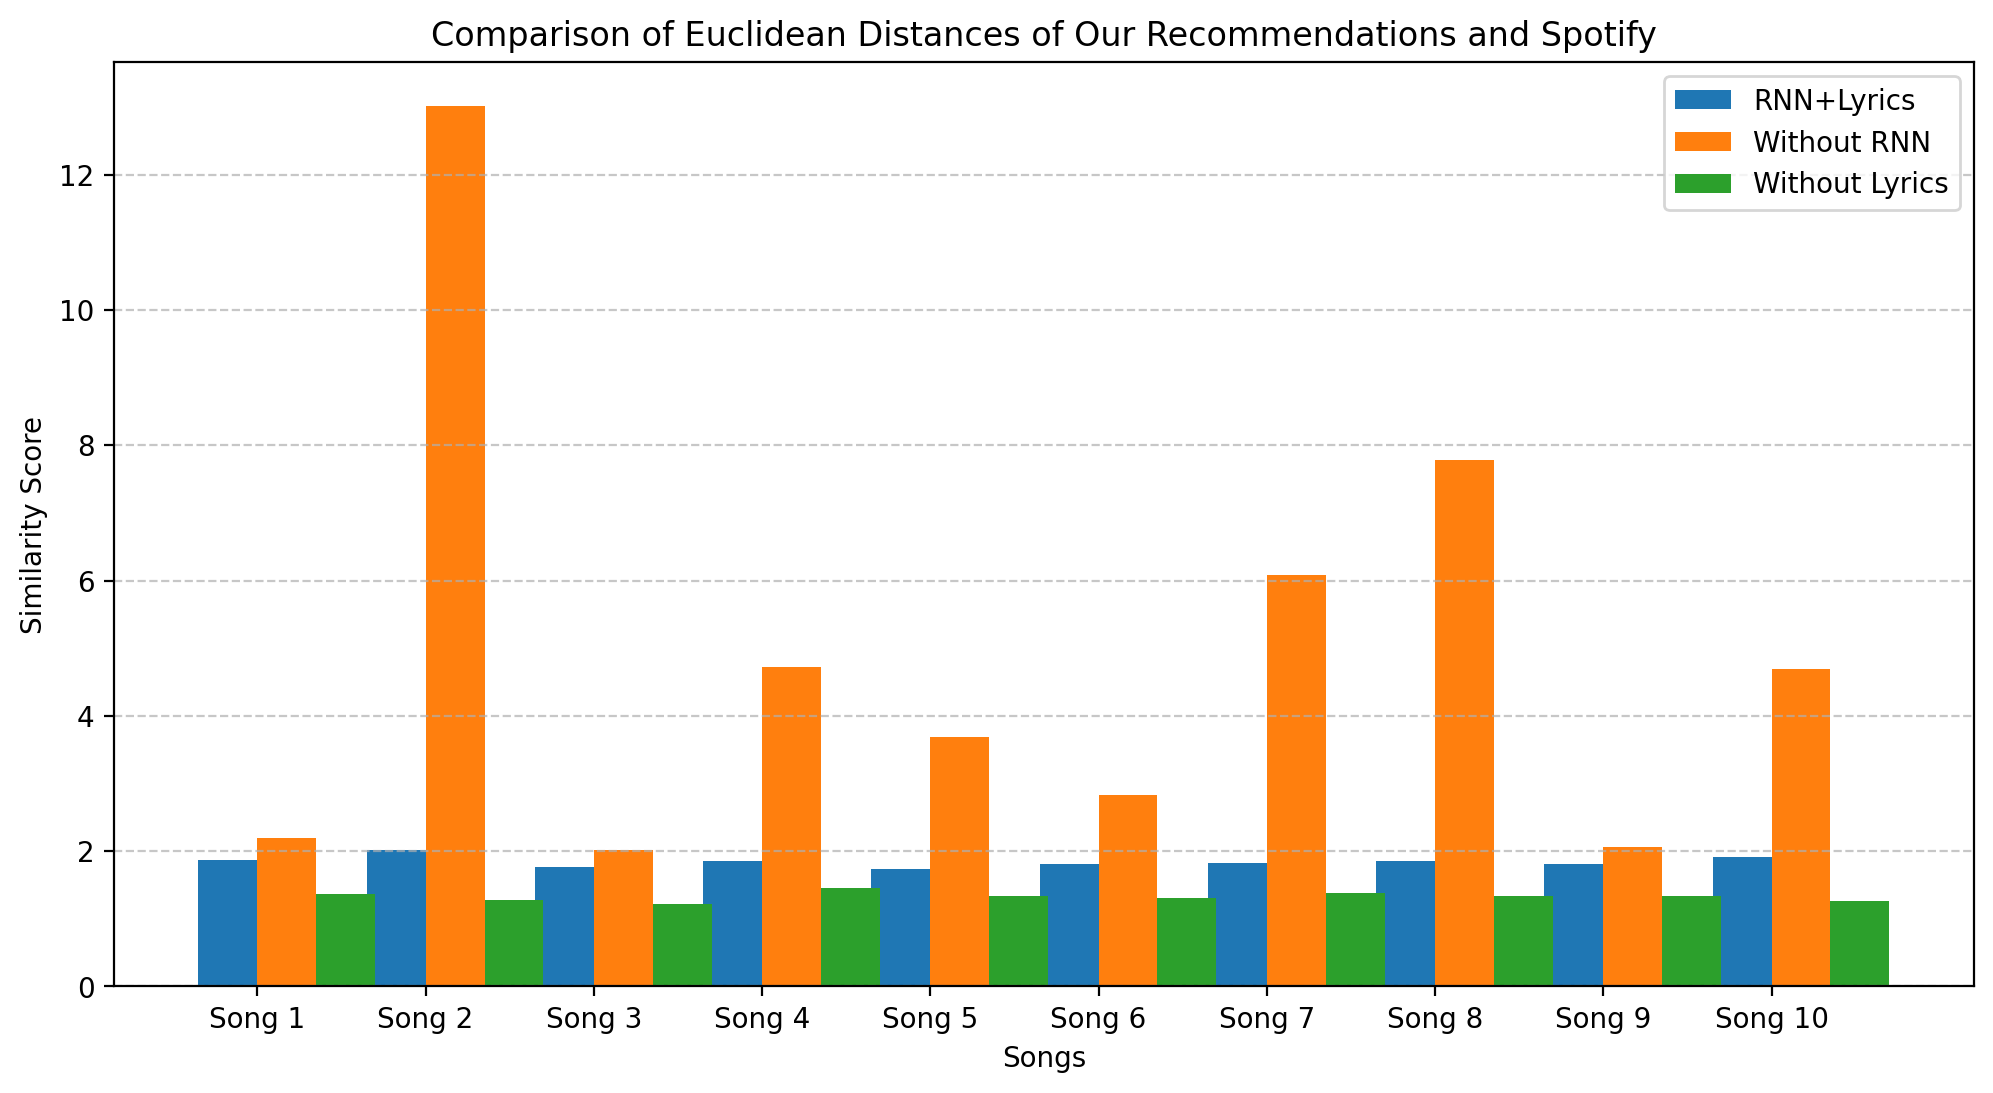

In [72]:
import matplotlib.pyplot as plt

rnn_lyrics = [1.870860464583459,
2.0124956563145764,
1.7609989657978797,
1.8539558357641899,
1.7356377060987644,
1.8086844811258185,
1.8221810357916215,
1.857452864811929,
1.8114270711291933,
1.9123509583315985
]
without_rnn = [2.1903769990609145,
13.007051437476452,
2.0155121067385218,
4.714721290673545,
3.6940682620350707,
2.827066168221043,
6.084447239668106,
7.774764222012763,
2.0678613309117333,
4.689565505067547]

without_lyrics = [
1.3706193326942206,
1.2708216300917896,
1.2168322931264042,
1.4480379561501788,
1.3435787248066673,
1.3016830290529573,
1.3866496871109233,
1.335457823254918,
1.3307610001197165,
1.2623593153364063]

n = len(rnn_lyrics)

bar_width = 0.35

index = np.arange(n)

plt.figure(figsize=(12, 6))

bars1 = plt.bar(index, rnn_lyrics, bar_width, label='RNN+Lyrics')
bars2 = plt.bar(index + bar_width, without_rnn, bar_width, label='Without RNN')
bars3 = plt.bar(index + (bar_width*2), without_lyrics, bar_width, label='Without Lyrics')

plt.xlabel('Songs')
plt.ylabel('Similarity Score')
plt.title('Comparison of Euclidean Distances of Our Recommendations and Spotify')
plt.xticks(index + bar_width / 2, [f'Song {i+1}' for i in range(n)]) 
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()